In [1]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc
import scipy.signal
from tqdm.notebook import tqdm

In [50]:
def get_vns(alpha=2, ks=None, vns=1024):
    if ks is None:    
        ks = np.linspace(0.5,1.5,128)
    vns = np.array([
        [(1.0/k) * np.abs(n)**alpha for n in range(0,vns)]
    for k in ks], dtype=np.float32)
    return vns

def get_dvns(alpha=2, ks=None, vns=1024):
    if ks is None:    
        ks = np.linspace(0.5,1.5,128)
    vns = np.array([
        [(alpha/k) * np.abs(n)**(alpha-1) for n in range(0,vns)]
    for k in ks], dtype=np.float32)
    return vns

def get_ddvns(alpha=2, ks=None, vns=1024):
    if ks is None:    
        ks = np.linspace(0.5,1.5,128)
    vns = np.array([
        [((alpha*(alpha-1))/k) * np.abs(n)**(alpha-2) for n in range(0,vns)]
    for k in ks], dtype=np.float32)
    return vns

alpha = 2
ks = np.linspace(0.5,1.5,64)
nvns = 32
vns = get_vns(alpha, ks=ks, vns=nvns)
dvns = get_dvns(alpha, ks=ks, vns=nvns)
ddvns = get_ddvns(alpha, ks=ks, vns=nvns)

d = 10
graph = py_gauge_mc.CudaGaugeTheory((d,d,d,d), vns)

In [51]:
graph.run_local_update(128)

In [54]:
graph.accumulate_plaquette_pairs?

Signature:
graph.accumulate_plaquette_pairs(
    max_absolute_integer,
    max_distance_from_root,
    plaquette_type,
)
Docstring: <no docstring>
Type:      builtin_function_or_method

In [55]:
data = []
max_int = 4

for p_type in tqdm(range(6)):
    graph.clear_plaquette_pairs()
    for _ in tqdm(range(8192), leave=False):
        graph.run_local_update(8)
        graph.accumulate_plaquette_pairs(max_int,(d+1)//2,p_type)
    data.append(graph.get_plaquette_pairs())

data = np.array(data)
data = np.transpose(data, (1, 2, 0, 3, 4, 5))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

In [62]:
data.shape

(64, 5, 6, 6, 9, 9)

In [65]:
total_counts = data.sum(axis=(-2,-1))
total_counts.shape

(64, 5, 6, 6)

In [67]:
pairs_probs = data / total_counts.reshape(list(total_counts.shape) + [1,1])
pairs_probs.shape

(64, 5, 6, 6, 9, 9)

In [68]:
import matplotlib
norm = matplotlib.colors.Normalize(vmin=ks[0], vmax=ks[-1])
cmap = lambda x: matplotlib.cm.jet(norm(x))

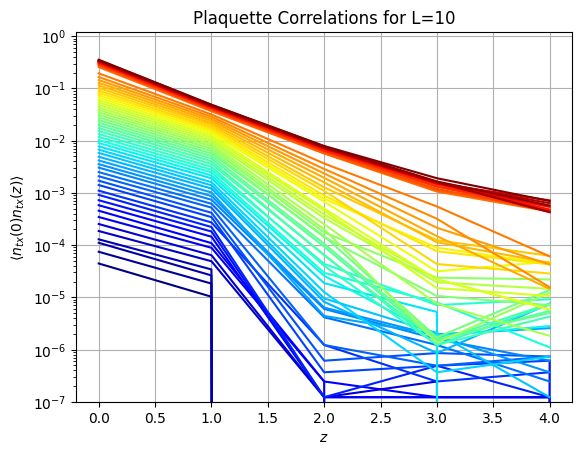

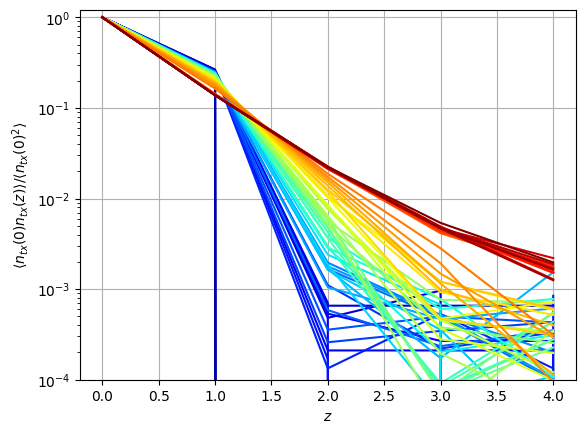

In [76]:
nns = np.einsum('i,j->ij', np.arange(-4,4+1), np.arange(-4,4+1))

pp_by_d = (pairs_probs[:,:,0,0] * nns.reshape((1, 9, 9))).sum(axis=(-2,-1))

for i in range(pp_by_d.shape[0]):
    plt.plot(abs(pp_by_d[i,:]), color=cmap(ks[i]))
plt.yscale('log')
plt.title('Plaquette Correlations for L=10')
plt.ylabel(r'$\langle n_{tx}(0) n_{tx}(z) \rangle$')
plt.xlabel(r'$z$')
plt.grid()
plt.ylim((1e-7,1.2))
plt.show()

for i in range(pp_by_d.shape[0]):
    plt.plot(abs(pp_by_d[i,:d//2])/abs(pp_by_d[i,0]), color=cmap(ks[i]))
plt.yscale('log')
plt.ylabel(r'$\langle n_{tx}(0) n_{tx}(z) \rangle / \langle n_{tx}(0)^2 \rangle$')
plt.xlabel(r'$z$')
plt.grid()
plt.ylim((1e-4,1.2))
plt.show()

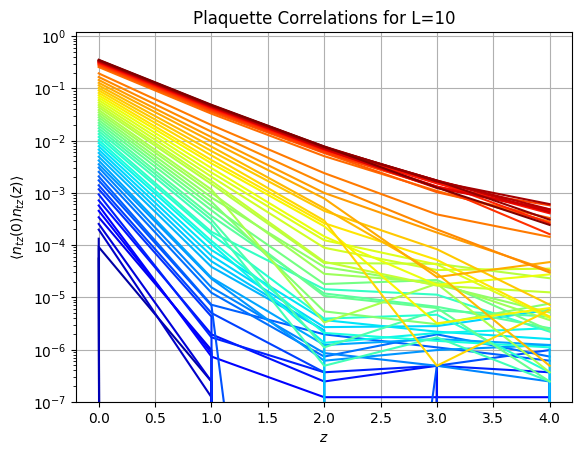

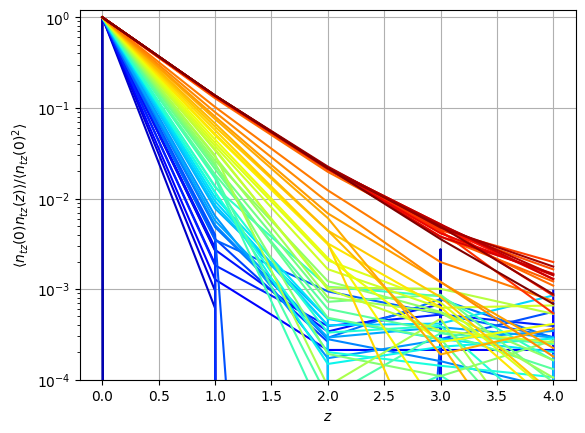

In [75]:
nns = np.einsum('i,j->ij', np.arange(-4,4+1), np.arange(-4,4+1))

pp_by_d = (pairs_probs[:,:,2,2] * nns.reshape((1, 9, 9))).sum(axis=(-2,-1))

for i in range(pp_by_d.shape[0]):
    plt.plot(abs(pp_by_d[i,:]), color=cmap(ks[i]))
plt.yscale('log')
plt.title('Plaquette Correlations for L=10')
plt.ylabel(r'$\langle n_{tz}(0) n_{tz}(z) \rangle$')
plt.xlabel(r'$z$')
plt.grid()
plt.ylim((1e-7,1.2))
plt.show()

for i in range(pp_by_d.shape[0]):
    plt.plot(abs(pp_by_d[i,:d//2])/abs(pp_by_d[i,0]), color=cmap(ks[i]))
plt.yscale('log')
plt.ylabel(r'$\langle n_{tz}(0) n_{tz}(z) \rangle / \langle n_{tz}(0)^2 \rangle$')
plt.xlabel(r'$z$')
plt.grid()
plt.ylim((1e-4,1.2))
plt.show()